In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
# Read Data

training_data_df = pd.read_csv('./prepped_data/training_data_ver_2.csv')
print(training_data_df.shape)
training_data_df.head()

(4348077, 294)


,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,(한강)오염행위 제한지역,(한강)폐기물매립시설 설치제한지역,가로구역별 최고높이 제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가·착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택 공급촉진지구,공공청사,공동구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,과밀억제권역,광로1류(폭 70M 이상),광로2류(폭 50M~70M),광로3류(폭 40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도:54-236m),대공방어협조구역(위탁고도:77-257m),대로1류(폭 35M~40M),대로2류(폭 30M~35M),대로3류(폭 25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획 입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향 검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상수원보호구역,생산녹지지역,소공원,소로1류(폭 10M~12M),소로2류(폭 8M~10M),소로3류(폭 8M 미만),소하천,소하천구역,수도공급시설,수평표면구역,시·도 생태·경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종 구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공:5km),제한보호구역(후방지역:500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭 20M~25M),중로2류(폭 15M~20M),중로3류(폭 12M~15M),중심대광장,중심상업지역,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역(민통선이남:300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,하수도,하수종말처리시설,하천,하천구역,학교,학교이적지,현상변경허가 대상구역,홍수관리구역,x_norm,y_norm,year_linear,month_sine,month_cosine
0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.666667,-0.866025,-0.500000
1,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.916667,-0.500000,0.866025
2,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [3]:
#column_map_df = pd.DataFrame({'col_name':training_data_df.columns.tolist(), 'col_map':[i for i in range(len(training_data_df.columns))]})

In [4]:
#column_map_df.to_csv('col_map.csv', index=False)

In [10]:
basedir = './feature_maps/'
col_map_df = pd.read_csv(basedir + 'col_map.csv')
floor_map_df = pd.read_csv(basedir + 'floor_map.csv')
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [11]:
col_map_df.head()

,col_name,col_map
0,trade_type,0
1,전용면적(㎡),1
2,금액(만원),2
3,월세(만원),3
4,가격/면적,4


In [12]:
floor_map_df.head()

,floor,floor_map
0,2,0
1,4,1
2,9,2
3,1,3
4,5,4


In [13]:
cat_cols_df.head()

,cat_cols
0,trade_type
1,층
2,건물나이
3,특수지구분명
4,표준지여부


In [15]:
col_map = {}
for i in range(col_map_df.shape[0]):
    col_map[col_map_df['col_name'][i]] = '{}'.format(col_map_df['col_map'][i])
col_map

{'trade_type': '0',
 '전용면적(㎡)': '1',
 '금액(만원)': '2',
 '월세(만원)': '3',
 '가격/면적': '4',
 '층': '5',
 '건물나이': '6',
 'target_log_transformed': '7',
 'target/area_log_transformed': '8',
 '특수지구분명': '9',
 '공시지가': '10',
 '표준지여부': '11',
 '지목코드': '12',
 '토지면적': '13',
 '용도지역코드1': '14',
 '용도지역코드2': '15',
 '지형높이코드': '16',
 '지형형상코드': '17',
 '도로접면코드': '18',
 '(한강)오염행위 제한지역': '19',
 '(한강)폐기물매립시설 설치제한지역': '20',
 '가로구역별 최고높이 제한지역': '21',
 '가스공급설비': '22',
 '가축사육제한구역': '23',
 '개발제한구역': '24',
 '개발진흥지구': '25',
 '개발행위허가제한지역': '26',
 '건축선': '27',
 '건축용도지역기타': '28',
 '건축용도지역미분류': '29',
 '건축허가·착공제한지역': '30',
 '경관광장': '31',
 '경관녹지': '32',
 '경관지구': '33',
 '경관지구기타': '34',
 '고도지구': '35',
 '고등학교': '36',
 '고속철도': '37',
 '공공공지': '38',
 '공공도서관': '39',
 '공공문화체육시설미분류': '40',
 '공공시설구역': '41',
 '공공주택지구': '42',
 '공공지원민간임대주택 공급촉진지구': '43',
 '공공청사': '44',
 '공동구': '45',
 '공원': '46',
 '공원마을지구(공원집단시설지구)': '47',
 '공원자연보존지구': '48',
 '공원자연환경지구': '49',
 '공익용산지': '50',
 '공익임지': '51',
 '공장설립승인지역': '52',
 '공장설립제한지역': '53',
 '공항소음피해예상지역': 

In [19]:
cat_cols = [cat_cols_df['cat_cols'][i] for i in range(cat_cols_df.shape[0])]
cat_cols.remove('층')
cat_cols.remove('건물나이')
cat_cols[:5]

['trade_type', '특수지구분명', '표준지여부', '지목코드', '용도지역코드1']

In [20]:
cat_cols_mapped = [col_map[v] for v in cat_cols]
print(len(cat_cols_mapped))
cat_cols_mapped[:5]

279


['0', '9', '11', '12', '14']

In [22]:
training_data_df.columns = [v for v in col_map.values()]

In [23]:
training_data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293
0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.666667,-0.866025,-0.500000
1,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.916667,-0.500000,0.866025
2,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.000000,0.000000,1.000000
3,1,77.75,32000,0,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.166667,0.866025,0.500000
4,1,77.75,37000,0,475.884244,1,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [111]:
trade_type_map_df = pd.read_csv(basedir + 'trade_type_map.csv')
trade_type_map_df.head()

,아파트_매매,아파트_전세,아파트_월세,다세대연립_매매,다세대연립_전세,다세대연립_월세,오피스텔_매매,오피스텔_전세,오피스텔_월세
0,0,1,2,3,4,5,6,7,8


In [112]:
trade_type_map = trade_type_map_df.to_dict(orient='records')[0]
trade_type_map

{'아파트_매매': 0,
 '아파트_전세': 1,
 '아파트_월세': 2,
 '다세대연립_매매': 3,
 '다세대연립_전세': 4,
 '다세대연립_월세': 5,
 '오피스텔_매매': 6,
 '오피스텔_전세': 7,
 '오피스텔_월세': 8}

In [114]:
training_data_df.shape

(4348077, 294)

In [115]:
no_monthly_pay_df = training_data_df[(training_data_df['0']!=2)&(training_data_df['0']!=5)&(training_data_df['0']!=8)].reset_index(drop=True)
print(no_monthly_pay_df.shape)
no_monthly_pay_df.head()

(3551733, 294)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293
0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.666667,-0.866025,-0.500000
1,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.916667,-0.500000,0.866025
2,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.000000,0.000000,1.000000
3,1,77.75,32000,0,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.166667,0.866025,0.500000
4,1,77.75,37000,0,475.884244,1,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [116]:
no_monthly_pay_df['0'].value_counts()

0    1083300
1    1066580
3     614107
4     515136
6     163652
7     108958
Name: 0, dtype: int64

In [118]:
no_monthly_pay_df = no_monthly_pay_df.drop(columns=['3'])

In [135]:
no_monthly_pay_df.head()

,0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293
0,0,77.75,57000,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.666667,-0.866025,-0.500000
1,0,77.75,57000,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.916667,-0.500000,0.866025
2,1,77.75,35000,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.000000,0.000000,1.000000
3,1,77.75,32000,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.425601,5.173547,7.166667,0.866025,0.500000
4,1,77.75,37000,475.884244,1,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0

In [136]:
test_data = no_monthly_pay_df.sample(frac=0.2)
train_data = no_monthly_pay_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(710347, 293)
(568277, 293)
(2273109, 293)


In [137]:
target_cols = ['금액(만원)', '가격/면적', 'target_log_transformed', 'target/area_log_transformed']
target_cols_mapped = [col_map[col] for col in target_cols]
target_cols_mapped

['2', '4', '7', '8']

In [138]:
x_test = test_data.drop(columns=target_cols_mapped)
y_test = test_data['2']
print(x_test.shape)
print(y_test.shape)

(710347, 289)
(710347,)


In [139]:
x_valid = valid_data.drop(columns=target_cols_mapped)
y_valid = valid_data['2']
print(x_valid.shape)
print(y_valid.shape)

(568277, 289)
(568277,)


In [140]:
x_train = train_data.drop(columns=target_cols_mapped)
y_train = train_data['2']
print(x_train.shape)
print(y_train.shape)

(2273109, 289)
(2273109,)


<AxesSubplot:>

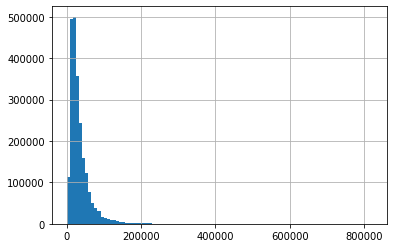

In [141]:
y_train.hist(bins=100)

# Training

In [ ]:
from sklearn.metrics import r2_score

# ML Models

## Light GBM

In [142]:
import lightgbm as lgb

In [143]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'seed': 42,
    'max_depth': -1,
    'lambda_l2':0,
    'metric':'rmse',
    'num_threads':6
}

In [144]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols_mapped)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols_mapped)

In [145]:
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.570989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 2273109, number of used features: 275
[LightGBM] [Info] Start training from score 34186.518516
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 13520.9
[100]	valid_0's rmse: 10119.6
[150]	valid_0's rmse: 8856.53
[200]	valid_0's rmse: 8234.23
[250]	valid_0's rmse: 7855.13
[300]	valid_0's rmse: 7585.28
[350]	valid_0's rmse: 7360.18
[400]	valid_0's rmse: 7165.05
[450]	valid_0's rmse: 7014.78
[500]	valid_0's rmse: 6890.77
[550]	valid_0's rmse: 6784.51
[600]	valid_0's rmse: 6688.18
[650]	valid_0's rmse: 6609.02
[700]	valid_0's rmse: 6532.46
[750]	valid_0's rmse: 6459.65
[800]	valid_0's rmse: 6393.74
[850]	valid_0's rmse: 6335.13
[900]	valid_0

[12500]	valid_0's rmse: 4523.76
[12550]	valid_0's rmse: 4522.41
[12600]	valid_0's rmse: 4521.05
[12650]	valid_0's rmse: 4519.18
[12700]	valid_0's rmse: 4517.81
[12750]	valid_0's rmse: 4516.33
[12800]	valid_0's rmse: 4515.39
[12850]	valid_0's rmse: 4514.1
[12900]	valid_0's rmse: 4512.65
[12950]	valid_0's rmse: 4511.52
[13000]	valid_0's rmse: 4510.48
[13050]	valid_0's rmse: 4509.65
[13100]	valid_0's rmse: 4508.58
[13150]	valid_0's rmse: 4507.37
[13200]	valid_0's rmse: 4506.06
[13250]	valid_0's rmse: 4504.96
[13300]	valid_0's rmse: 4503.49
[13350]	valid_0's rmse: 4502.37
[13400]	valid_0's rmse: 4500.92
[13450]	valid_0's rmse: 4500.07
[13500]	valid_0's rmse: 4498.89
[13550]	valid_0's rmse: 4497.58
[13600]	valid_0's rmse: 4496.6
[13650]	valid_0's rmse: 4495.47
[13700]	valid_0's rmse: 4493.84
[13750]	valid_0's rmse: 4492.54
[13800]	valid_0's rmse: 4491.36
[13850]	valid_0's rmse: 4490.16
[13900]	valid_0's rmse: 4488.6
[13950]	valid_0's rmse: 4487.59
[14000]	valid_0's rmse: 4486.16
[14050]	val

KeyboardInterrupt: 

In [ ]:
pred = bst.predict(x_test, num_iteration=bst.best_iteration)

In [48]:
r2_score(y_test, pred)

0.9789456187044302

In [53]:
x_test.head()

,0,1,3,5,6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293
583973,0,58.55,0,22,18,1,3958000,0,8,50978.2,15,0,3,7,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.203702,3.123268,12.000000,0.000000e+00,1.000000e+00
3783220,4,22.02,0,4,3,1,5148000,0,8,235.8,14,0,2,4,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.618829,7.860411,13.500000,1.224647e-16,-1.000000e+00
4143194,6,43.42,0,12,11,1,6440000,0,8,3174.2,22,0,2,7,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.874870,14.837939,9.166667,8.660254e-01,5.000000e-01
1180413,0,84.99,0,13,13,1,9560000,0,8,1516.7,22,0,2,2,5,0,0,1,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,20.418919,15.064310,14.166667,8.660254e-01,5.000000e-01
1811315,1,84.60,0,8,5,1,5400000,0,8,4969.1,16,0,2,4,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,

In [79]:
type(x_test['289'])

pandas.core.series.Series

In [81]:
y_test.shape

(869615,)

In [80]:
x_test['289'].shape

(869615,)

In [83]:
x_test['289'].values.shape

(869615,)

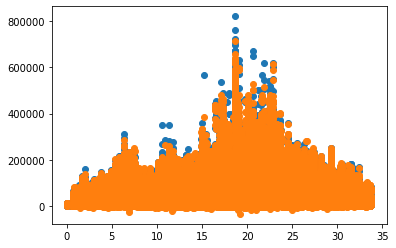

<Figure size 432x288 with 0 Axes>

In [87]:
plt.scatter(x_test['289'], y_test)
plt.scatter(x_test['289'], pred)
plt.show()
plt.clf()

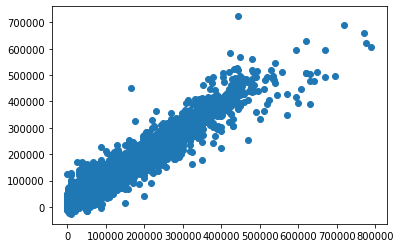

<Figure size 432x288 with 0 Axes>

In [106]:
plt.scatter(y_test, pred)
plt.show()
plt.clf()

In [88]:
import lightgbm as lgb

In [89]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'seed': 42,
    'max_depth': -1,
    'lambda_l2':0,
    'metric':'rmse',
    'num_threads':6
}

In [95]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols_mapped)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols_mapped)

In [96]:
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.723615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2637
[LightGBM] [Info] Number of data points in the train set: 2782770, number of used features: 279


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 9.877030
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.472727
[100]	valid_0's rmse: 0.367845
[150]	valid_0's rmse: 0.336013
[200]	valid_0's rmse: 0.320861
[250]	valid_0's rmse: 0.311617
[300]	valid_0's rmse: 0.304888
[350]	valid_0's rmse: 0.299738
[400]	valid_0's rmse: 0.295644
[450]	valid_0's rmse: 0.292244
[500]	valid_0's rmse: 0.28928
[550]	valid_0's rmse: 0.286561
[600]	valid_0's rmse: 0.284132
[650]	valid_0's rmse: 0.282067
[700]	valid_0's rmse: 0.280039
[750]	valid_0's rmse: 0.278291
[800]	valid_0's rmse: 0.276559
[850]	valid_0's rmse: 0.275097
[900]	valid_0's rmse: 0.273761
[950]	valid_0's rmse: 0.272551
[1000]	valid_0's rmse: 0.271331
[1050]	valid_0's rmse: 0.270178
[1100]	valid_0's rmse: 0.269109
[1150]	valid_0's rmse: 0.268183
[1200]	valid_0's rmse: 0.267244
[1250]	valid_0's rmse: 0.266257
[1300]	valid_0's rmse: 0.265414
[1350]	valid_0's rmse: 0.264585
[1400]	valid_0's rmse: 0.26383
[1450]	vali

[12700]	valid_0's rmse: 0.225532
[12750]	valid_0's rmse: 0.225478
[12800]	valid_0's rmse: 0.225435
[12850]	valid_0's rmse: 0.225378
[12900]	valid_0's rmse: 0.225329
[12950]	valid_0's rmse: 0.225282
[13000]	valid_0's rmse: 0.225244
[13050]	valid_0's rmse: 0.225199
[13100]	valid_0's rmse: 0.225148
[13150]	valid_0's rmse: 0.225103
[13200]	valid_0's rmse: 0.225049
[13250]	valid_0's rmse: 0.224994
[13300]	valid_0's rmse: 0.22494
[13350]	valid_0's rmse: 0.224893
[13400]	valid_0's rmse: 0.22484
[13450]	valid_0's rmse: 0.224792
[13500]	valid_0's rmse: 0.224731
[13550]	valid_0's rmse: 0.22468
[13600]	valid_0's rmse: 0.224638
[13650]	valid_0's rmse: 0.224586
[13700]	valid_0's rmse: 0.224546
[13750]	valid_0's rmse: 0.224491
[13800]	valid_0's rmse: 0.224438
[13850]	valid_0's rmse: 0.224398
[13900]	valid_0's rmse: 0.224341
[13950]	valid_0's rmse: 0.224296
[14000]	valid_0's rmse: 0.224248
[14050]	valid_0's rmse: 0.224216
[14100]	valid_0's rmse: 0.224173
[14150]	valid_0's rmse: 0.224124
[14200]	valid

[25200]	valid_0's rmse: 0.2174
[25250]	valid_0's rmse: 0.217377
[25300]	valid_0's rmse: 0.217353
[25350]	valid_0's rmse: 0.217326
[25400]	valid_0's rmse: 0.217306
[25450]	valid_0's rmse: 0.217281
[25500]	valid_0's rmse: 0.217258
[25550]	valid_0's rmse: 0.217237
[25600]	valid_0's rmse: 0.217217
[25650]	valid_0's rmse: 0.217196
[25700]	valid_0's rmse: 0.217176
[25750]	valid_0's rmse: 0.21715
[25800]	valid_0's rmse: 0.217127
[25850]	valid_0's rmse: 0.217104
[25900]	valid_0's rmse: 0.217083
[25950]	valid_0's rmse: 0.217064
[26000]	valid_0's rmse: 0.217046
[26050]	valid_0's rmse: 0.217028
[26100]	valid_0's rmse: 0.217013
[26150]	valid_0's rmse: 0.21699
[26200]	valid_0's rmse: 0.216973
[26250]	valid_0's rmse: 0.216947
[26300]	valid_0's rmse: 0.216919
[26350]	valid_0's rmse: 0.216901
[26400]	valid_0's rmse: 0.216879
[26450]	valid_0's rmse: 0.216854
[26500]	valid_0's rmse: 0.216836
[26550]	valid_0's rmse: 0.216814
[26600]	valid_0's rmse: 0.216792
[26650]	valid_0's rmse: 0.216772
[26700]	valid_

[37700]	valid_0's rmse: 0.213311
[37750]	valid_0's rmse: 0.2133
[37800]	valid_0's rmse: 0.213288
[37850]	valid_0's rmse: 0.213276
[37900]	valid_0's rmse: 0.213264
[37950]	valid_0's rmse: 0.213254
[38000]	valid_0's rmse: 0.213244
[38050]	valid_0's rmse: 0.213236
[38100]	valid_0's rmse: 0.21322
[38150]	valid_0's rmse: 0.213211
[38200]	valid_0's rmse: 0.213201
[38250]	valid_0's rmse: 0.213192
[38300]	valid_0's rmse: 0.213182
[38350]	valid_0's rmse: 0.213172
[38400]	valid_0's rmse: 0.213158
[38450]	valid_0's rmse: 0.213148
[38500]	valid_0's rmse: 0.213138
[38550]	valid_0's rmse: 0.213129
[38600]	valid_0's rmse: 0.213116
[38650]	valid_0's rmse: 0.2131
[38700]	valid_0's rmse: 0.213085
[38750]	valid_0's rmse: 0.213073
[38800]	valid_0's rmse: 0.213061
[38850]	valid_0's rmse: 0.213049
[38900]	valid_0's rmse: 0.213041
[38950]	valid_0's rmse: 0.213028
[39000]	valid_0's rmse: 0.213018
[39050]	valid_0's rmse: 0.213006
[39100]	valid_0's rmse: 0.212992
[39150]	valid_0's rmse: 0.212982
[39200]	valid_0

[50200]	valid_0's rmse: 0.210783
[50250]	valid_0's rmse: 0.210776
[50300]	valid_0's rmse: 0.210763
[50350]	valid_0's rmse: 0.210754
[50400]	valid_0's rmse: 0.210744
[50450]	valid_0's rmse: 0.210736
[50500]	valid_0's rmse: 0.210725
[50550]	valid_0's rmse: 0.210718
[50600]	valid_0's rmse: 0.210711
[50650]	valid_0's rmse: 0.210706
[50700]	valid_0's rmse: 0.210699
[50750]	valid_0's rmse: 0.210693
[50800]	valid_0's rmse: 0.210686
[50850]	valid_0's rmse: 0.210678
[50900]	valid_0's rmse: 0.210666
[50950]	valid_0's rmse: 0.21066
[51000]	valid_0's rmse: 0.210648
[51050]	valid_0's rmse: 0.210637
[51100]	valid_0's rmse: 0.210627
[51150]	valid_0's rmse: 0.210617
[51200]	valid_0's rmse: 0.210607
[51250]	valid_0's rmse: 0.2106
[51300]	valid_0's rmse: 0.210587
[51350]	valid_0's rmse: 0.210582
[51400]	valid_0's rmse: 0.210571
[51450]	valid_0's rmse: 0.210558
[51500]	valid_0's rmse: 0.210551
[51550]	valid_0's rmse: 0.210544
[51600]	valid_0's rmse: 0.210535
[51650]	valid_0's rmse: 0.210527
[51700]	valid

[62700]	valid_0's rmse: 0.209055
[62750]	valid_0's rmse: 0.209051
[62800]	valid_0's rmse: 0.209045
[62850]	valid_0's rmse: 0.209041
[62900]	valid_0's rmse: 0.209036
[62950]	valid_0's rmse: 0.209027
[63000]	valid_0's rmse: 0.209022
[63050]	valid_0's rmse: 0.209014
[63100]	valid_0's rmse: 0.209008
[63150]	valid_0's rmse: 0.209002
[63200]	valid_0's rmse: 0.208995
[63250]	valid_0's rmse: 0.208989
[63300]	valid_0's rmse: 0.208978
[63350]	valid_0's rmse: 0.20897
[63400]	valid_0's rmse: 0.208965
[63450]	valid_0's rmse: 0.208956
[63500]	valid_0's rmse: 0.208951
[63550]	valid_0's rmse: 0.208942
[63600]	valid_0's rmse: 0.208935
[63650]	valid_0's rmse: 0.208931
[63700]	valid_0's rmse: 0.208925
[63750]	valid_0's rmse: 0.208922
[63800]	valid_0's rmse: 0.208918
[63850]	valid_0's rmse: 0.208914
[63900]	valid_0's rmse: 0.208909
[63950]	valid_0's rmse: 0.208902
[64000]	valid_0's rmse: 0.208898
[64050]	valid_0's rmse: 0.208893
[64100]	valid_0's rmse: 0.208884
[64150]	valid_0's rmse: 0.20888
[64200]	vali

[75150]	valid_0's rmse: 0.207815
[75200]	valid_0's rmse: 0.207808
[75250]	valid_0's rmse: 0.207805
[75300]	valid_0's rmse: 0.207797
[75350]	valid_0's rmse: 0.207793
[75400]	valid_0's rmse: 0.207789
[75450]	valid_0's rmse: 0.207787
[75500]	valid_0's rmse: 0.207781
[75550]	valid_0's rmse: 0.207775
[75600]	valid_0's rmse: 0.20777
[75650]	valid_0's rmse: 0.207766
[75700]	valid_0's rmse: 0.207758
[75750]	valid_0's rmse: 0.207756
[75800]	valid_0's rmse: 0.207753
[75850]	valid_0's rmse: 0.207747
[75900]	valid_0's rmse: 0.207741
[75950]	valid_0's rmse: 0.207737
[76000]	valid_0's rmse: 0.207735
[76050]	valid_0's rmse: 0.207734
[76100]	valid_0's rmse: 0.207733
[76150]	valid_0's rmse: 0.20773
[76200]	valid_0's rmse: 0.207727
[76250]	valid_0's rmse: 0.207724
[76300]	valid_0's rmse: 0.207719
[76350]	valid_0's rmse: 0.207716
[76400]	valid_0's rmse: 0.20771
[76450]	valid_0's rmse: 0.207705
[76500]	valid_0's rmse: 0.2077
[76550]	valid_0's rmse: 0.207697
[76600]	valid_0's rmse: 0.207692
[76650]	valid_0

[87650]	valid_0's rmse: 0.206808
[87700]	valid_0's rmse: 0.206805
[87750]	valid_0's rmse: 0.206803
[87800]	valid_0's rmse: 0.206799
[87850]	valid_0's rmse: 0.206796
[87900]	valid_0's rmse: 0.206794
[87950]	valid_0's rmse: 0.206789
[88000]	valid_0's rmse: 0.206785
[88050]	valid_0's rmse: 0.206783
[88100]	valid_0's rmse: 0.206781
[88150]	valid_0's rmse: 0.20678
[88200]	valid_0's rmse: 0.206777
[88250]	valid_0's rmse: 0.206774
[88300]	valid_0's rmse: 0.206769
[88350]	valid_0's rmse: 0.206764
[88400]	valid_0's rmse: 0.20676
[88450]	valid_0's rmse: 0.206755
[88500]	valid_0's rmse: 0.20675
[88550]	valid_0's rmse: 0.206747
[88600]	valid_0's rmse: 0.206745
[88650]	valid_0's rmse: 0.206741
[88700]	valid_0's rmse: 0.206738
[88750]	valid_0's rmse: 0.206733
[88800]	valid_0's rmse: 0.206729
[88850]	valid_0's rmse: 0.206725
[88900]	valid_0's rmse: 0.206721
[88950]	valid_0's rmse: 0.206718
[89000]	valid_0's rmse: 0.206714
[89050]	valid_0's rmse: 0.20671
[89100]	valid_0's rmse: 0.206708
[89150]	valid_

[100150]	valid_0's rmse: 0.205991
[100200]	valid_0's rmse: 0.205989
[100250]	valid_0's rmse: 0.205986
[100300]	valid_0's rmse: 0.205982
[100350]	valid_0's rmse: 0.205979
[100400]	valid_0's rmse: 0.205977
[100450]	valid_0's rmse: 0.205972
[100500]	valid_0's rmse: 0.205969
[100550]	valid_0's rmse: 0.205967
[100600]	valid_0's rmse: 0.205965
[100650]	valid_0's rmse: 0.205963
[100700]	valid_0's rmse: 0.205958
[100750]	valid_0's rmse: 0.205956
[100800]	valid_0's rmse: 0.205954
[100850]	valid_0's rmse: 0.205953
[100900]	valid_0's rmse: 0.205952
[100950]	valid_0's rmse: 0.205949
[101000]	valid_0's rmse: 0.205946
[101050]	valid_0's rmse: 0.205942
[101100]	valid_0's rmse: 0.20594
[101150]	valid_0's rmse: 0.205937
[101200]	valid_0's rmse: 0.205934
[101250]	valid_0's rmse: 0.205929
[101300]	valid_0's rmse: 0.205926
[101350]	valid_0's rmse: 0.205922
[101400]	valid_0's rmse: 0.205919
[101450]	valid_0's rmse: 0.205917
[101500]	valid_0's rmse: 0.205912
[101550]	valid_0's rmse: 0.20591
[101600]	valid_0

[112250]	valid_0's rmse: 0.205282
[112300]	valid_0's rmse: 0.205279
[112350]	valid_0's rmse: 0.205278
[112400]	valid_0's rmse: 0.205276
[112450]	valid_0's rmse: 0.205275
[112500]	valid_0's rmse: 0.205272
[112550]	valid_0's rmse: 0.205272
[112600]	valid_0's rmse: 0.20527
[112650]	valid_0's rmse: 0.205268
[112700]	valid_0's rmse: 0.205265
[112750]	valid_0's rmse: 0.205262
[112800]	valid_0's rmse: 0.20526
[112850]	valid_0's rmse: 0.205258
[112900]	valid_0's rmse: 0.205257
[112950]	valid_0's rmse: 0.205254
[113000]	valid_0's rmse: 0.205252
[113050]	valid_0's rmse: 0.205249
[113100]	valid_0's rmse: 0.205247
[113150]	valid_0's rmse: 0.205245
[113200]	valid_0's rmse: 0.205243
[113250]	valid_0's rmse: 0.205241
[113300]	valid_0's rmse: 0.205239
[113350]	valid_0's rmse: 0.205237
[113400]	valid_0's rmse: 0.205233
[113450]	valid_0's rmse: 0.205231
[113500]	valid_0's rmse: 0.205228
[113550]	valid_0's rmse: 0.205227
[113600]	valid_0's rmse: 0.205224
[113650]	valid_0's rmse: 0.205222
[113700]	valid_0

In [97]:
pred = bst.predict(x_test, num_iteration=bst.best_iteration)

In [98]:
from sklearn.metrics import r2_score

In [102]:
r2_score(np.e**y_test, np.e**pred)

0.9774329915822901

<AxesSubplot:>

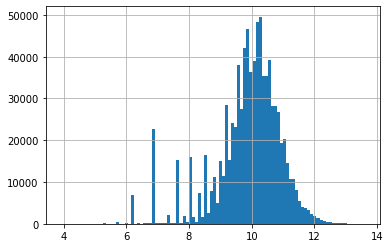

In [103]:
y_test.hist(bins=100)

<AxesSubplot:>

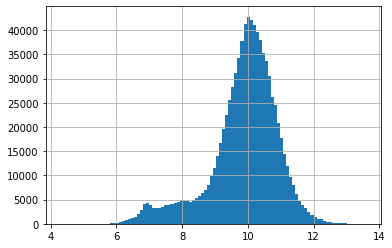

In [104]:
pd.Series(pred).hist(bins=100)

<AxesSubplot:>

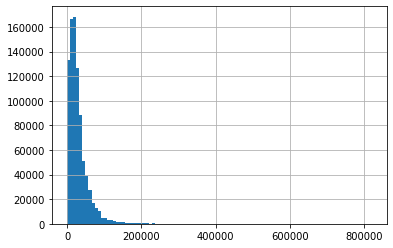

In [105]:
(np.e**y_test).hist(bins=100)

<AxesSubplot:>

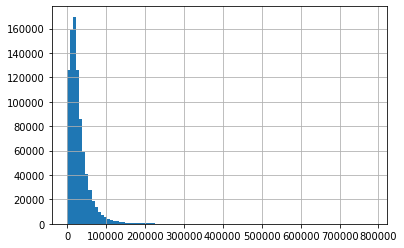

In [106]:
pd.Series((np.e**pred)).hist(bins=100)

In [109]:
e_y_test = np.e**y_test
e_pred = np.e**pred

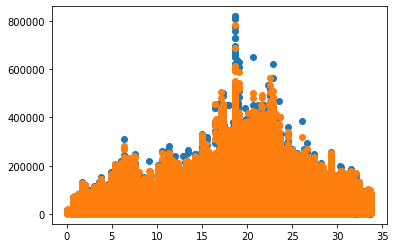

<Figure size 432x288 with 0 Axes>

In [110]:
plt.scatter(x_test['289'], e_y_test)
plt.scatter(x_test['289'], e_pred)
plt.show()
plt.clf()

# CatBoost

In [147]:
from catboost import Pool, CatBoostRegressor

In [149]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols_mapped)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols_mapped)
test_pool = Pool(x_test, y_test, cat_features=cat_cols_mapped)

In [160]:
model = CatBoostRegressor(task_type='GPU', iterations=100000)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)

Learning rate set to 0.01327
0:	learn: 29600.0650075	test: 29577.7853207	best: 29577.7853207 (0)	total: 583ms	remaining: 16h 12m 16s
1:	learn: 29599.9084162	test: 29577.5048402	best: 29577.5048402 (1)	total: 1.52s	remaining: 21h 4m 46s
2:	learn: 29599.9064214	test: 29577.5028439	best: 29577.5028439 (2)	total: 2.37s	remaining: 21h 58m 15s
3:	learn: 29599.8056838	test: 29577.4180006	best: 29577.4180006 (3)	total: 3.25s	remaining: 22h 33m 37s
4:	learn: 29599.7189096	test: 29577.2852452	best: 29577.2852452 (4)	total: 4.13s	remaining: 22h 57m 4s
5:	learn: 29599.6321351	test: 29577.2023975	best: 29577.2023975 (5)	total: 5s	remaining: 23h 10m 24s
6:	learn: 29599.6071999	test: 29577.2023975	best: 29577.2023975 (5)	total: 5.88s	remaining: 23h 18m 49s
7:	learn: 29580.9667211	test: 29558.5647610	best: 29558.5647610 (7)	total: 6.76s	remaining: 23h 27m 26s
8:	learn: 29580.8828858	test: 29558.4608861	best: 29558.4608861 (8)	total: 7.64s	remaining: 23h 34m 17s
9:	learn: 29580.8020443	test: 29558.3290

78:	learn: 29511.7326156	test: 29489.0768000	best: 29489.0768000 (78)	total: 1m 8s	remaining: 1d 4m 38s
79:	learn: 29511.7126080	test: 29489.0778011	best: 29489.0768000 (78)	total: 1m 9s	remaining: 23h 58m 52s
80:	learn: 29511.7046049	test: 29489.0717942	best: 29489.0717942 (80)	total: 1m 9s	remaining: 23h 54m 36s
81:	learn: 29511.6685912	test: 29489.0267425	best: 29489.0267425 (81)	total: 1m 10s	remaining: 23h 56m 55s
82:	learn: 29511.6595877	test: 29489.0267425	best: 29489.0267425 (81)	total: 1m 11s	remaining: 23h 58m 52s
83:	learn: 29511.6455824	test: 29489.0197344	best: 29489.0197344 (83)	total: 1m 12s	remaining: 1d 5m 42s
84:	learn: 29511.6265751	test: 29489.0017137	best: 29489.0017137 (84)	total: 1m 13s	remaining: 1d 6m 30s
85:	learn: 29511.6125697	test: 29488.9967080	best: 29488.9967080 (85)	total: 1m 14s	remaining: 1d 8m 21s
86:	learn: 29511.5925621	test: 29488.9796884	best: 29488.9796884 (86)	total: 1m 15s	remaining: 1d 3m 41s
87:	learn: 29511.5855594	test: 29488.9716792	best:

155:	learn: 29463.7173404	test: 29444.3676426	best: 29444.3676426 (155)	total: 2m 17s	remaining: 1d 25m 43s
156:	learn: 29463.5219478	test: 29444.1931777	best: 29444.1931777 (156)	total: 2m 18s	remaining: 1d 25m 36s
157:	learn: 29463.2714426	test: 29443.9695803	best: 29443.9695803 (157)	total: 2m 19s	remaining: 1d 25m 36s
158:	learn: 29463.2634264	test: 29443.9475213	best: 29443.9475213 (158)	total: 2m 20s	remaining: 1d 25m 30s
159:	learn: 29463.2313615	test: 29443.9114247	best: 29443.9114247 (159)	total: 2m 20s	remaining: 1d 25m 14s
160:	learn: 29462.9006909	test: 29443.6417013	best: 29443.6417013 (160)	total: 2m 21s	remaining: 1d 25m 18s
161:	learn: 29462.8405686	test: 29443.5544668	best: 29443.5544668 (161)	total: 2m 22s	remaining: 1d 22m 14s
162:	learn: 29462.6341476	test: 29443.3378836	best: 29443.3378836 (162)	total: 2m 23s	remaining: 1d 24m 56s
163:	learn: 29462.4718156	test: 29443.3318673	best: 29443.3318673 (163)	total: 2m 24s	remaining: 1d 24m 58s
164:	learn: 29462.3104847	te

232:	learn: 29399.8762470	test: 29384.4473337	best: 29384.4473337 (232)	total: 3m 26s	remaining: 1d 33m 56s
233:	learn: 29384.9130817	test: 29369.6612621	best: 29369.6612621 (233)	total: 3m 27s	remaining: 1d 34m 56s
234:	learn: 29384.8136166	test: 29369.5617452	best: 29369.5617452 (234)	total: 3m 28s	remaining: 1d 35m 50s
235:	learn: 29384.4901012	test: 29369.1164281	best: 29369.1164281 (235)	total: 3m 29s	remaining: 1d 36m 43s
236:	learn: 29384.3896298	test: 29369.0128884	best: 29369.0128884 (236)	total: 3m 30s	remaining: 1d 38m 7s
237:	learn: 29384.3886251	test: 29369.0128884	best: 29369.0128884 (236)	total: 3m 31s	remaining: 1d 36m 6s
238:	learn: 29384.3685308	test: 29368.9877574	best: 29368.9877574 (238)	total: 3m 32s	remaining: 1d 35m 57s
239:	learn: 29384.2670543	test: 29368.8962801	best: 29368.8962801 (239)	total: 3m 33s	remaining: 1d 36m 34s
240:	learn: 29384.2670543	test: 29368.8962801	best: 29368.8962801 (239)	total: 3m 34s	remaining: 1d 36m 29s
241:	learn: 29384.2670543	test